### Exercise 1

In [1]:
import torch

class MyLinear(torch.nn.Module):
    '''
    Custom implementation of torch.nn.Linear for exercise 1.
    
    The size of the matrix A is (out_features, in_features) because then the
    transpose has size (in_features, out_features) allowing us to left-multiply
    the input tensor x of size (1, in_features).
    '''
    def __init__(self, in_features, out_features, device=None, dtype=None):
        super().__init__()
        tensor_params = dict(device=device, dtype=dtype, requires_grad=True)
        self.A = torch.nn.Parameter(torch.randn((out_features, in_features), **tensor_params))
        self.b = torch.nn.Parameter(torch.zeros((out_features,), **tensor_params))
    
    def forward(self, x):
        return x @ self.A.T + self.b

### Exercise 2

In [2]:
import torch
from itertools import islice

def unknown_linear_random_sampler(in_features, out_features, noise_factor=0.05, device=None, dtype=None):
    '''
    Generator that yields random sample following some unknown function.
    '''
    tensor_params = dict(device=device, dtype=dtype)
    A = torch.randn((out_features, in_features), **tensor_params)
    b = torch.randn((out_features,), **tensor_params)
    
    while True:
        x = torch.rand((in_features,), **tensor_params)
        e = torch.randn((out_features,), **tensor_params)
        yield {'x': x, 'y': A @ x + b + noise_factor * e}

def take_batch_from_sampler(sampler, batch_size=256):
    samples = islice(sampler, batch_size)
    xs, ys = zip(*((sample['x'], sample['y']) for sample in samples))
    xs = torch.stack(xs)
    ys = torch.stack(ys)
    return xs, ys

In [3]:
import torch

def select_device(use_cuda=True):
    use_cuda = use_cuda and torch.cuda.is_available()
    name = 'cuda:0' if use_cuda else 'cpu'
    return torch.device(name)

In [4]:
import matplotlib.pyplot as plt

def plot_1d_tensors(xs, ys_lists, plotter=plt.plot, xlabel=None, ylabel=None, title=None):
    cmap = plt.cm.get_cmap('brg', len(ys_lists))
    convert = lambda z: z.cpu().detach().numpy() if torch.is_tensor(z) else z
    xs = list(map(convert, xs))
    for n, ys in enumerate(ys_lists):
        ys = list(map(convert, ys))
        plotter(xs, ys, color=cmap(n))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [5]:
from tqdm import trange

def visualize_training(model, optimizer, loss_function, sampler, epochs=30, batch_size=256, visualize=True):
    losses = []
    model.train()
    for epoch in trange(epochs):
        xs, ys = take_batch_from_sampler(sampler, batch_size)
        optimizer.zero_grad()
        y_pred = model(xs)
        loss = loss_function(y_pred, ys)
        loss.backward()
        optimizer.step()
        losses.append([epoch, loss])
    if visualize:
        xs, ys = zip(*losses)
        plot_1d_tensors(xs, [ys], xlabel="Epochs", ylabel="Losses", title="Change of losses over time")

100%|█████████████████████████████████████████| 300/300 [00:06<00:00, 49.66it/s]


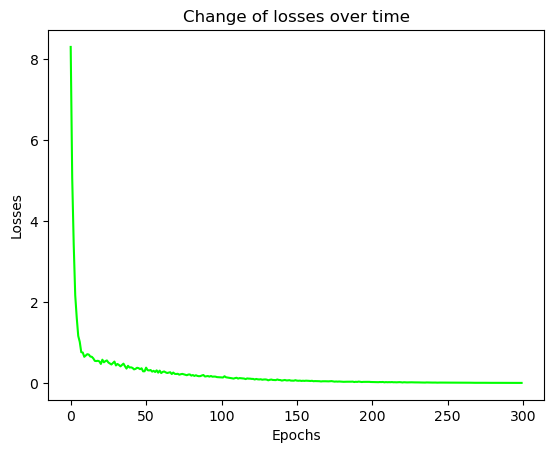

In [6]:
device = select_device()
epochs = 300
in_features = 5
out_features = 2
step_size = 0.1
batch_size = 256

model = MyLinear(in_features, out_features, device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=step_size)
loss_function = torch.nn.MSELoss()
sampler = unknown_linear_random_sampler(in_features, out_features, device=device)
visualize_training(model, optimizer, loss_function, sampler, epochs, batch_size)

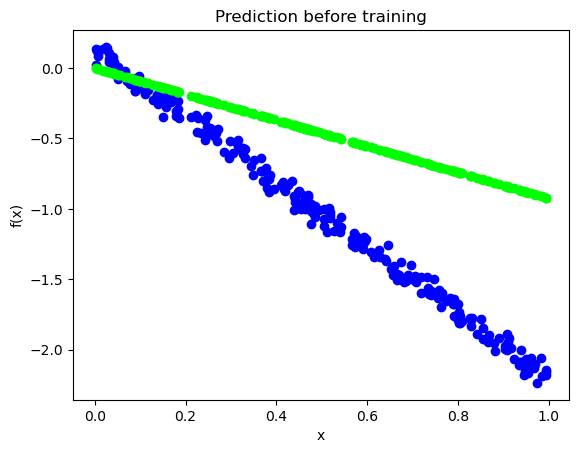

100%|█████████████████████████████████████████| 300/300 [00:05<00:00, 53.01it/s]


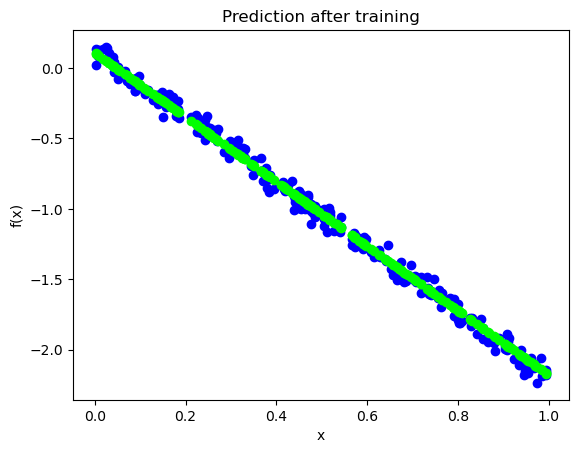

In [7]:
device = select_device()
epochs = 300
in_features = 1
out_features = 1
step_size = 0.1
batch_size = 256

model = MyLinear(in_features, out_features, device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=step_size)
loss_function = torch.nn.MSELoss()
sampler = unknown_linear_random_sampler(in_features, out_features, device=device)
xs, ys = take_batch_from_sampler(sampler, batch_size)

params = dict(xs=xs, xlabel="x", ylabel="f(x)", plotter=plt.scatter)

plot_1d_tensors(ys_lists=[ys, model(xs)], title="Prediction before training", **params)
visualize_training(model, optimizer, loss_function, sampler, epochs, batch_size, visualize=False)
plot_1d_tensors(ys_lists=[ys, model(xs)], title="Prediction after training", **params)

### Aufgabe 3

In [8]:
import torch

class MyPolynomial(torch.nn.Module):
    '''
    A module that can learn an arbitrary polynomial function.
    
    We use the horner scheme to discribe any polynomial function
    using a combination of linear functions.
    
    Example
    -------
    p(x) = a * x ** 2 + b * x + c
    p(x) = z(x) * x + c, z(x) = a * x + b    
    '''
    def __init__(self, degree, device=None, dtype=None):
        super().__init__()
        tensor_params = dict(device=device, dtype=dtype)
        self.coefficients = torch.nn.Parameter(torch.randn((degree + 1, 1), **tensor_params), requires_grad=True)
        self.exponentials = torch.arange(0, degree + 1, **tensor_params)
    
    def forward(self, x):
        return torch.pow(x, self.exponentials) @ self.coefficients

In [9]:
import torch

def unknown_polynomial_random_sampler(degree, xaxis=[-1, 1], noise_factor=0.1, device=None, dtype=None):
    '''
    Generator that yields random sample following some unknown function.
    '''
    tensor_params = dict(device=device, dtype=dtype)
    bs = [torch.randn(1, **tensor_params) for _ in range(degree + 1)]

    def f(x):
        z = 0
        for b in bs:
            z = z * x + b
        return z
            
    while True:
        x = (xaxis[0] - xaxis[1]) * torch.rand(1, **tensor_params) + xaxis[1]
        e = torch.randn(1, **tensor_params)
        yield {'x': x, 'y': f(x) + noise_factor * e * (xaxis[1] - xaxis[0]) ** 2}

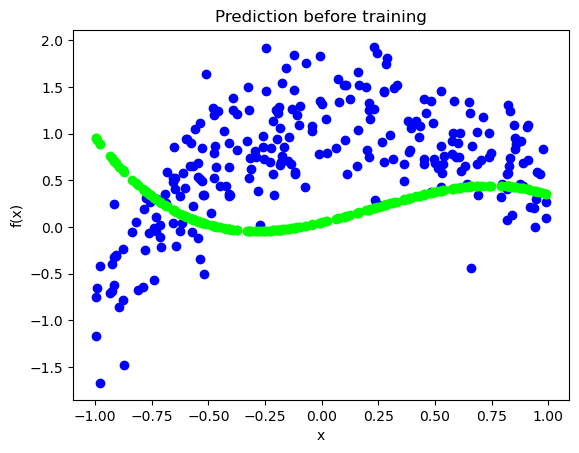

100%|█████████████████████████████████████████| 300/300 [00:12<00:00, 24.89it/s]


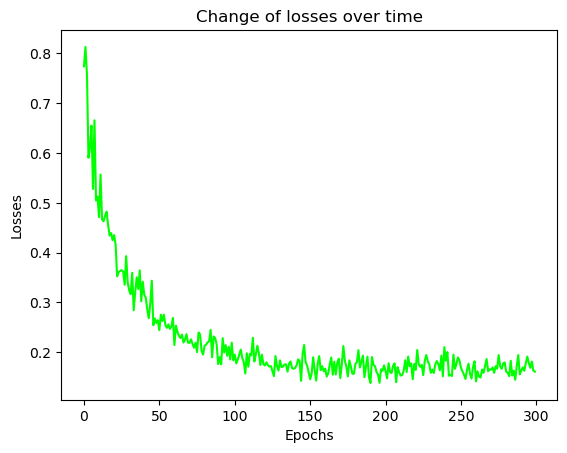

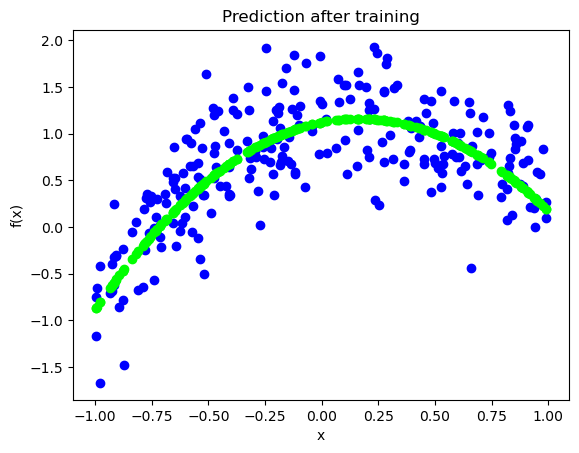

In [10]:
device = select_device()
epochs = 300
degree = 3
step_size = 0.1
batch_size = 256

model = MyPolynomial(degree, device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=step_size)
loss_function = torch.nn.MSELoss()
sampler = unknown_polynomial_random_sampler(degree, xaxis=[-1, 1], device=device)
xs, ys = take_batch_from_sampler(sampler, batch_size)

params = dict(xs=xs, xlabel="x", ylabel="f(x)", plotter=plt.scatter)

plot_1d_tensors(ys_lists=[ys, model(xs)], title="Prediction before training", **params)
visualize_training(model, optimizer, loss_function, sampler, epochs, batch_size, visualize=True)
plot_1d_tensors(ys_lists=[ys, model(xs)], title="Prediction after training", **params)

### Aufgabe 4

In [11]:
import torch

class MySimpleNetwork(torch.nn.Module):
    '''
    Custom implementation of torch.nn.Linear for exercise 4.
    '''
    def __init__(self, in_features, out_features, device=None, dtype=None):
        super().__init__()
        params = dict(device=device, dtype=dtype)
        hidden_features = max(in_features // 2, 2)
        self.model = torch.nn.Sequential(
            torch.nn.Linear(in_features, hidden_features, **params),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden_features, out_features, **params)
        )

    
    def forward(self, x):
        return self.model(x)

100%|█████████████████████████████████████████| 300/300 [00:06<00:00, 45.03it/s]


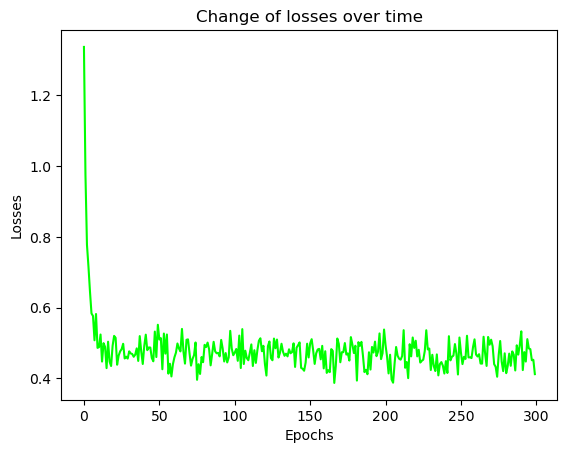

In [12]:
device = select_device()
epochs = 300
in_features = 5
out_features = 2
step_size = 0.1
batch_size = 256

model = MySimpleNetwork(in_features, out_features, device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=step_size)
loss_function = torch.nn.MSELoss()
sampler = unknown_linear_random_sampler(in_features, out_features, device=device)
visualize_training(model, optimizer, loss_function, sampler, epochs, batch_size)

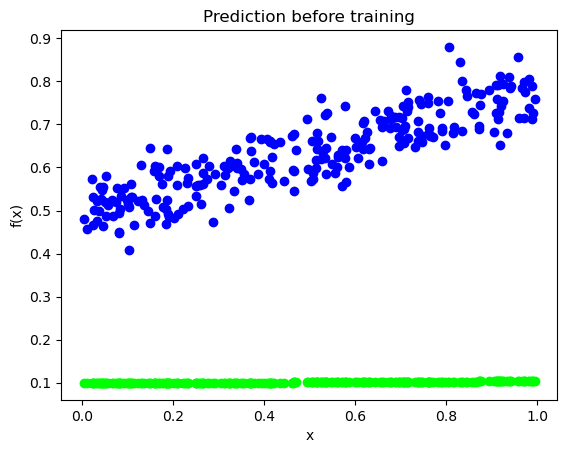

100%|█████████████████████████████████████████| 300/300 [00:06<00:00, 47.17it/s]


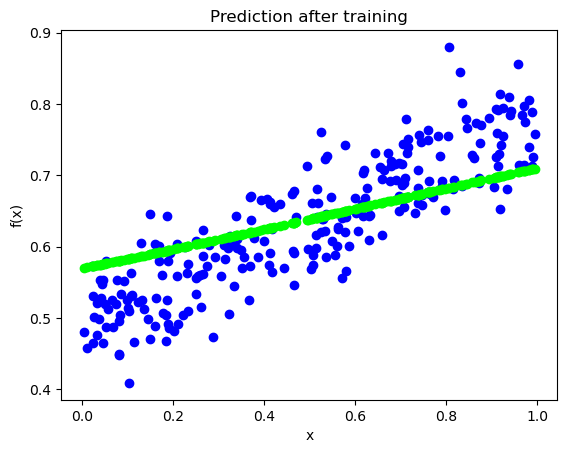

In [13]:
device = select_device()
epochs = 300
in_features = 1
out_features = 1
step_size = 0.1
batch_size = 256

model = MySimpleNetwork(in_features, out_features, device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=step_size)
loss_function = torch.nn.MSELoss()
sampler = unknown_linear_random_sampler(in_features, out_features, device=device)
xs, ys = take_batch_from_sampler(sampler, batch_size)

params = dict(xs=xs, xlabel="x", ylabel="f(x)", plotter=plt.scatter)

plot_1d_tensors(ys_lists=[ys, model(xs)], title="Prediction before training", **params)
visualize_training(model, optimizer, loss_function, sampler, epochs, batch_size, visualize=False)
plot_1d_tensors(ys_lists=[ys, model(xs)], title="Prediction after training", **params)

Since we already know that the function is linear, both models get better over time and have the around same performance.